In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-11-14 21:13:44--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-11-14 21:13:44 (5.61 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



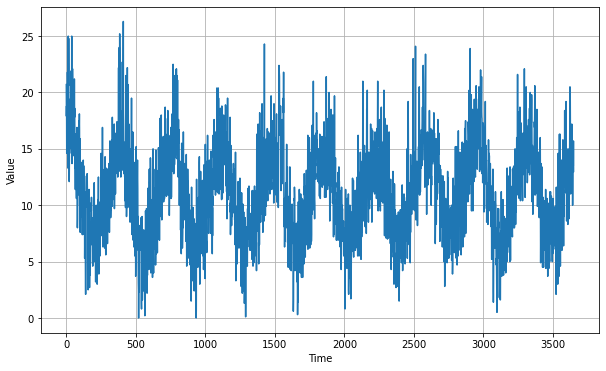

In [16]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  i = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(int(i))
    i+=1
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [17]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [19]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 35s 66ms/step - loss: 31.1715 - mae: 31.6699 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 67ms/step - loss: 30.5964 - mae: 31.0948 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 64ms/step - loss: 29.7069 - mae: 30.2051 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 61ms/step - loss: 28.5905 - mae: 29.0887 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 63ms/step - loss: 27.2278 - mae: 27.7258 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 63ms/step - loss: 25.5257 - mae: 26.0235 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 62ms/step - loss: 23.3491 - mae: 23.8466 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 66ms/step - loss: 20.5688 - mae: 21.0657 - lr: 2.2387e

(1e-08, 0.0001, 0.0, 60.0)

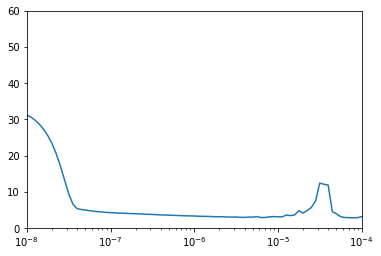

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=250, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=10, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
10/10 [==============================] - 5s 51ms/step - loss: 5.0244 - mae: 5.5057
Epoch 2/100
10/10 [==============================] - 1s 61ms/step - loss: 3.9009 - mae: 4.3771
Epoch 3/100
10/10 [==============================] - 1s 56ms/step - loss: 3.5141 - mae: 3.9877
Epoch 4/100
10/10 [==============================] - 1s 62ms/step - loss: 3.0333 - mae: 3.5037
Epoch 5/100
10/10 [==============================] - 1s 60ms/step - loss: 2.8129 - mae: 3.2836
Epoch 6/100
10/10 [==============================] - 1s 61ms/step - loss: 2.7795 - mae: 3.2473
Epoch 7/100
10/10 [==============================] - 1s 59ms/step - loss: 2.7575 - mae: 3.2219
Epoch 8/100
10/10 [==============================] - 1s 58ms/step - loss: 2.8336 - mae: 3.3022
Epoch 9/100
10/10 [==============================] - 1s 59ms/step - loss: 2.7824 - mae: 3.2520
Epoch 10/100
10/10 [==============================] - 1s 59ms/step - loss: 2.7434 - mae: 3.2108
Epoch 11/100
10/10 [=============================

In [36]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

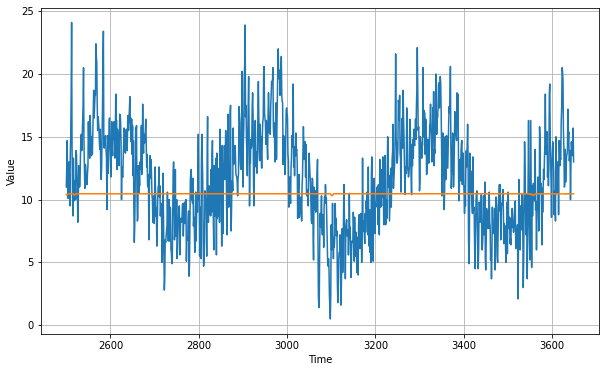

In [37]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [38]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

3.3714087

In [39]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[10.419456 10.361461 10.378862 ... 10.465557 10.465557 10.465557]
